# Fit a Binary Logistic Regression Model to a Dataset

## 1. Build a Classification Model



In this exercise, you will fit a binary logistic regression model to the baby name dataset you used in the previous exercise. This model will predict the sex of a person based on their age, name, and state they were born in. To train the model, you will use the data found in baby-names/names-classifier.

#### Importing data

In [1]:
# Import required modules
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder.appName('week10') \
        .getOrCreate()


In [2]:
df = spark.read.parquet("/home/ram/share/650/dsc650-master/data/baby-names/names_classifier")
df.show()

+------+-----+---+---+
|  name|state|sex|age|
+------+-----+---+---+
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
|Joseph|   PA|  M| 26|
+------+-----+---+---+
only showing top 20 rows



In [3]:
df.count()

308180519

In [4]:
whole_df = df # taking backup of dataframe

distinct_df = df.distinct() # removing duplicates from df

df = distinct_df # copying distinct records into the main df

In [5]:
df.count()

5933561

### a. Prepare in Input Features


First, you will need to prepare each of the input features. While age is a numeric feature, state and name are not. These need to be converted into numeric vectors before you can train the model. Use a StringIndexer along with the OneHotEncoderEstimator to convert the name, state, and sex columns into numeric vectors. Use the VectorAssembler to combine the name, state, and age vectors into a single features vector. Your final dataset should contain a column called features containing the prepared vector and a column called label containing the sex of the person.



 #### Use a StringIndexer along with the OneHotEncoderEstimator to convert the name, state, and sex columns into numeric vectors

In [6]:
name_indexer = StringIndexer(inputCol = "name", outputCol= "nameInd")
name_trsf = name_indexer.fit(df).transform(df) # transform(df.select("name"))
name_ohe = OneHotEncoder(inputCol = "nameInd", outputCol= "name_ohe")
name_featurevect = name_ohe.transform(name_trsf)

In [7]:
name_featurevect

DataFrame[name: string, state: string, sex: string, age: int, nameInd: double, name_ohe: vector]

In [8]:
state_indexer = StringIndexer(inputCol = "state", outputCol= "stateInd")
state_trsf = state_indexer.fit(name_featurevect).transform(name_featurevect) # transform(df.select("state"))
state_ohe= OneHotEncoder(inputCol = "stateInd", outputCol= "state_ohe")
state_featurevect = state_ohe.transform(state_trsf)

In [9]:
state_featurevect

DataFrame[name: string, state: string, sex: string, age: int, nameInd: double, name_ohe: vector, stateInd: double, state_ohe: vector]

In [10]:
state_featurevect.show()

+-------+-----+---+---+-------+--------------------+--------+---------------+
|   name|state|sex|age|nameInd|            name_ohe|stateInd|      state_ohe|
+-------+-----+---+---+-------+--------------------+--------+---------------+
|  Aaden|   AL|  M|  7| 4000.0|(31313,[4000],[1.0])|    16.0|(50,[16],[1.0])|
|  Aaden|   AZ|  M|  4| 4000.0|(31313,[4000],[1.0])|    23.0|(50,[23],[1.0])|
|  Aaden|   CT|  M|  9| 4000.0|(31313,[4000],[1.0])|    33.0|(50,[33],[1.0])|
|  Aaden|   MS|  M|  5| 4000.0|(31313,[4000],[1.0])|    24.0|(50,[24],[1.0])|
|  Aadya|   MA|  F|  2| 7564.0|(31313,[7564],[1.0])|    18.0|(50,[18],[1.0])|
| Aaiden|   IL|  M|  2| 9589.0|(31313,[9589],[1.0])|     3.0| (50,[3],[1.0])|
|Aaliyah|   CO|  F| 10| 1523.0|(31313,[1523],[1.0])|    27.0|(50,[27],[1.0])|
|Aaliyah|   DE|  F|  5| 1523.0|(31313,[1523],[1.0])|    47.0|(50,[47],[1.0])|
|Aaliyah|   LA|  F| 15| 1523.0|(31313,[1523],[1.0])|    11.0|(50,[11],[1.0])|
|Aaliyah|   NE|  F| 13| 1523.0|(31313,[1523],[1.0])|    36.0|(50

In [11]:
sex_indexer = StringIndexer(inputCol = "sex", outputCol= "sex_label")
sex_label = sex_indexer.fit(state_featurevect).transform(state_featurevect) # transform(df.select("sex"))
sex_ohe = OneHotEncoder(inputCol = "sex_label", outputCol= "sex_ohe_label")
features_label = sex_ohe.transform(sex_label)

In [12]:
features_label

DataFrame[name: string, state: string, sex: string, age: int, nameInd: double, name_ohe: vector, stateInd: double, state_ohe: vector, sex_label: double, sex_ohe_label: vector]

In [13]:
features_label.show()

+-------+-----+---+---+-------+--------------------+--------+---------------+---------+-------------+
|   name|state|sex|age|nameInd|            name_ohe|stateInd|      state_ohe|sex_label|sex_ohe_label|
+-------+-----+---+---+-------+--------------------+--------+---------------+---------+-------------+
|  Aaden|   AL|  M|  7| 4000.0|(31313,[4000],[1.0])|    16.0|(50,[16],[1.0])|      1.0|    (1,[],[])|
|  Aaden|   AZ|  M|  4| 4000.0|(31313,[4000],[1.0])|    23.0|(50,[23],[1.0])|      1.0|    (1,[],[])|
|  Aaden|   CT|  M|  9| 4000.0|(31313,[4000],[1.0])|    33.0|(50,[33],[1.0])|      1.0|    (1,[],[])|
|  Aaden|   MS|  M|  5| 4000.0|(31313,[4000],[1.0])|    24.0|(50,[24],[1.0])|      1.0|    (1,[],[])|
|  Aadya|   MA|  F|  2| 7564.0|(31313,[7564],[1.0])|    18.0|(50,[18],[1.0])|      0.0|(1,[0],[1.0])|
| Aaiden|   IL|  M|  2| 9589.0|(31313,[9589],[1.0])|     3.0| (50,[3],[1.0])|      1.0|    (1,[],[])|
|Aaliyah|   CO|  F| 10| 1523.0|(31313,[1523],[1.0])|    27.0|(50,[27],[1.0])|     

In [14]:
df.columns

['name', 'state', 'sex', 'age']

#### Use the VectorAssembler to combine the name, state, and age vectors into a single features vector

In [15]:
features_assembler = VectorAssembler(inputCols = ["name_ohe","state_ohe","age"],outputCol = "features")
assembler_op = features_assembler.transform(features_label)

In [16]:
assembler_op

DataFrame[name: string, state: string, sex: string, age: int, nameInd: double, name_ohe: vector, stateInd: double, state_ohe: vector, sex_label: double, sex_ohe_label: vector, features: vector]

In [17]:
final_dataset = assembler_op.select('features', 'sex_label')
final_dataset.columns

['features', 'sex_label']

In [18]:
final_dataset.show()

+--------------------+---------+
|            features|sex_label|
+--------------------+---------+
|(31364,[4000,3132...|      1.0|
|(31364,[4000,3133...|      1.0|
|(31364,[4000,3134...|      1.0|
|(31364,[4000,3133...|      1.0|
|(31364,[7564,3133...|      0.0|
|(31364,[9589,3131...|      1.0|
|(31364,[1523,3134...|      0.0|
|(31364,[1523,3136...|      0.0|
|(31364,[1523,3132...|      0.0|
|(31364,[1523,3134...|      0.0|
|(31364,[1523,3132...|      0.0|
|(31364,[5641,3131...|      1.0|
|(31364,[4063,3132...|      1.0|
|(31364,[4063,3133...|      1.0|
|(31364,[120,31321...|      1.0|
|(31364,[120,31350...|      1.0|
|(31364,[120,31331...|      1.0|
|(31364,[120,31331...|      1.0|
|(31364,[120,31338...|      1.0|
|(31364,[120,31328...|      1.0|
+--------------------+---------+
only showing top 20 rows



## 2. Fit and Evaluate the Model


Fit the model as a logistic regression model with the following parameters. LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8). Provide the area under the ROC curve for the model.

In [19]:
lr = LogisticRegression(labelCol = 'sex_label',featuresCol = 'features', maxIter=10, regParam=0.3, elasticNetParam=0.8)
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.8)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: sex_label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained

In [20]:
# test train split
train_data, test_data = final_dataset.randomSplit([0.7, 0.3], seed = 1)

In [21]:
print("Training data set count : " + str(train_data.count()))
print("\n")
print("Test data set count : " + str(test_data.count()))

Training data set count : 4154257


Test data set count : 1779304


In [22]:
# Fit the logistic regression model
lr_model = lr.fit(train_data)

In [23]:
# print fitted logistic regression model summary
lr_model_summary = lr_model.summary

In [24]:
# print the roc (of trained data) as a data frame 
lr_model_summary.roc.show(10)

+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|1.0|1.0|
|1.0|1.0|
+---+---+



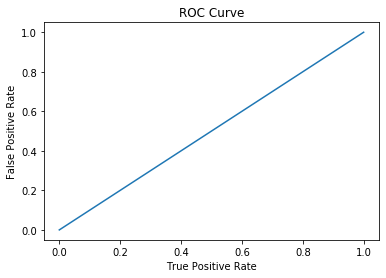

In [30]:
# plotting ROC Curve
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [31]:
# print area under curve (of trained data) 
print("Training set areaUnderROC : ")
print(lr_model_summary.areaUnderROC)

Training set areaUnderROC : 
0.5


#### Model Evaluation

In [32]:
predict_train = lr_model.transform(train_data)
predict_test = lr_model.transform(test_data)

In [40]:
predict_test.columns

['features', 'sex_label', 'rawPrediction', 'probability', 'prediction']

In [42]:
predict_test.select("features", "sex_label", "prediction").show(10)

+--------------------+---------+----------+
|            features|sex_label|prediction|
+--------------------+---------+----------+
|(31364,[0,31319,3...|      0.0|       0.0|
|(31364,[0,31327,3...|      1.0|       0.0|
|(31364,[0,31336,3...|      1.0|       0.0|
|(31364,[0,31339,3...|      1.0|       0.0|
|(31364,[0,31339,3...|      1.0|       0.0|
|(31364,[0,31341,3...|      1.0|       0.0|
|(31364,[0,31345,3...|      1.0|       0.0|
|(31364,[0,31353,3...|      1.0|       0.0|
|(31364,[0,31359,3...|      1.0|       0.0|
|(31364,[1,31313,3...|      1.0|       0.0|
+--------------------+---------+----------+
only showing top 10 rows



In [43]:
predict_test.select("features", "sex_label", "rawPrediction", "prediction", "probability").show(5)

+--------------------+---------+--------------------+----------+--------------------+
|            features|sex_label|       rawPrediction|prediction|         probability|
+--------------------+---------+--------------------+----------+--------------------+
|(31364,[0,31319,3...|      0.0|[0.23189024886690...|       0.0|[0.55771417127057...|
|(31364,[0,31327,3...|      1.0|[0.23189024886690...|       0.0|[0.55771417127057...|
|(31364,[0,31336,3...|      1.0|[0.23189024886690...|       0.0|[0.55771417127057...|
|(31364,[0,31339,3...|      1.0|[0.23189024886690...|       0.0|[0.55771417127057...|
|(31364,[0,31339,3...|      1.0|[0.23189024886690...|       0.0|[0.55771417127057...|
+--------------------+---------+--------------------+----------+--------------------+
only showing top 5 rows



In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [45]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = "sex_label")


In [46]:
#check metric used in evaluator
evaluator.getMetricName()

'areaUnderROC'

In [47]:
print("The area under ROC for train set is {}". format(evaluator.evaluate(predict_train)))

The area under ROC for train set is 0.5


In [48]:
print("The area under ROC for test set is {}". format(evaluator.evaluate(predict_test)))

The area under ROC for test set is 0.5


Are under ROC of 0.5, conveys that the model has poor class separation capacity. The model must be further improved by hypertuning the parameters of the model.